Importing libraries

In [46]:
import numpy as np
from datetime import datetime
from itertools import groupby

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
import math
import torch as T
from torch.autograd import Variable
import numpy as np
import pdb
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
!pip install torchsummaryX --quiet
from torchsummaryX import summary as summaryX
from torchsummary import summary
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Preparing Seq_MNIST data set alpha=9, ends=5 as paper

In [21]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),

    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))])

)

def prepare_data(data):
  seq_data=[]
  seq_label=[]
  k=1
  temp_data=[]
  temp_label=[]
  ends=5
  alpha=9
  total=3*alpha+2*ends
  for image,label in data:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`

    temp_label.append(label)
    if k%4==1:
      for i in range(1,alpha+1,2):
        temp_data.append(image*0.1*(i))

      temp_data.append(image)

      for i in range(alpha):
        temp_data.append(image*0.1*(alpha-i))

    elif k%4==0:
      temp_data.append(image)
      l = len(temp_data)
      for i in range(alpha):
        temp_data[l-alpha+i]=temp_data[l-alpha+i]+image*0.1*(i)

        if (i+1)%2==1:
          temp_data.append(image*0.1*(alpha-i))
      seq_data.append(torch.cat(temp_data, dim=0).reshape((41,1,32,32)))
      seq_label.append(torch.tensor(temp_label).reshape((4,1)))
      temp_data=[]
      temp_label=[]
    else:
      l = len(temp_data)
      temp_data.append(image)
      for i in range(alpha):
        temp_data[l-alpha+i]=temp_data[l-alpha+i]+image*0.1*(i)
        temp_data.append(image*0.1*(alpha-i))
    k=k+1
  return torch.cat(seq_data, dim=1), torch.cat(seq_label, dim=1)

train_seq_image, train_seq_label = prepare_data(train_data)
test_seq_image, test_seq_label = prepare_data(test_data)


In [26]:
train_seq_image[:,0,:,:].shape

torch.Size([41, 32, 32])

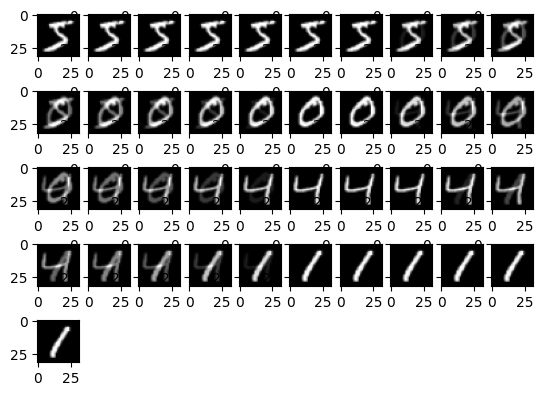

In [24]:
c=1
for i in train_seq_image[:,0,:,:]:

  plt.subplot(5, 10, c)
  plt.imshow(i.reshape(32,32), cmap='gray')
  c=c+1
plt.show()

LeNet++ implementation from Wen, Y., Zhang, K., Li, Z., Qiao, Y.: A discriminative feature learning approach for
deep face recognition. In: Proceedings of the European Conference on Computer
Vision. pp. 499–515. Springer (2016)


In [66]:
class LeNetpp(nn.Module):
    def __init__(self):
        super(LeNetpp, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten())

        self.fc = nn.Linear(2048, 3)
        self.relu = nn.PReLU()
        self.fc2 = nn.Linear(3,11)
        self.softmax= nn.Softmax(dim=1)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.fc(out)
        v = self.relu(out)
        f = self.fc2(v)
        out = self.softmax(f)


        return out, v,f

In [56]:
model = LeNetpp()

x = torch.randn(41,1,32,32)
output,_,f = model(x)
print(model)
print("output.shape : ",output.shape)

output.shape :  torch.Size([41, 32, 16, 16])
output.shape :  torch.Size([41, 64, 8, 8])
output.shape :  torch.Size([41, 2048])
output.shape :  torch.Size([41, 3])
output.shape :  torch.Size([41, 11])
LeNetpp(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), paddin

In [67]:
model = LeNetpp().to(DEVICE)
criterion = nn.CTCLoss(blank=10, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

In [88]:
epochs=10000
for _ in range(epochs):
    # ============================================ TRAINING =====================================================
    train_correct = 0
    train_total = 0
    for i in range(len(train_seq_image)):
        seq = train_seq_image[:,i,:,:].reshape(41,1,32,32)
        label = train_seq_label[:,i].reshape((1,4))
        output, _, _ = model(seq.cuda())

        optimizer.zero_grad()
        y_pred = model(seq.cuda())
        input_lengths = torch.full(size=(1,), fill_value=41, dtype=torch.long)
        target_lengths = torch.randint(low=1, high=41, size=(1,), dtype=torch.long)
        loss = criterion(output, label, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(output, dim=1)  # max_index.shape == torch.Size([32, 64])

        raw_prediction = list(max_index.detach().cpu().numpy())  # len(raw_prediction) == 32
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != 10])
        if len(prediction) == len(label) and torch.all(prediction.eq(label)):
            train_correct += 1
        train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total," loss= ",loss)


RuntimeError: ignored

In [ ]:
output

tensor([2], dtype=torch.int32)

Common parts of CTC and Radial CTC loss implemented using https://ogunlao.github.io/blog/2020/07/17/breaking-down-ctc-loss.html explanation

In [ ]:
def ctc_loss_base(pred, token):
    '''
    :param pred: (Time, batch, voca_size+1)
    :param pred_len: (batch)
    :param token: (batch, U)
    :param token_len: (batch)
    '''
    Time, batch, L= pred.size(0), pred.size(1), pred.size(2)
    U = token.size(1)

    pred_token=pred[:,:,0]

    for i in range(2*U):

      if i%2==1:
        pred_token.append(pred[:,:,0])
      else:
        pred_token.append(pred[:,token[:,int(i/2)]])
    alpha=np.zeros(pred.shape)

    for t in range(Time):
      for s in range(2*U+1):
        if s==0 and t==0:
          alpha[0,:,0]=pred_token[0,:,0]
        elif s==1 and t==0:
          alpha[0,:,1]=pred_token[0,:,1]
        else:
          if s %2==0:
            if t>0:
              if s>0:
                alpha[t,:,s] = (alpha[t-1,:,s]+ alpha[t-1,:,s-1])*pred_token[t,:,s]
              else:
                alpha[t,:,s] = (alpha[t-1,:,s])*pred_token[t,:,s]
          else:
            if s>2
              if t>1:
                mask = token[:,int((s-1)/2)]==token[:,int((s-3)/2)]
                alpha[t,mask,s] = (alpha[t-1,mask,s]+ alpha[t-1,mask,s-1])*pred_token[t,mask,s]
                alpha[t,~mask,s] = (alpha[t-1,~mask,s]+alpha[t-1,~mask,s-1]+alpha[t-2,~mask,s-2])*pred_token[t,~mask,s]
              elif t>0:
                alpha[t,:,s] = (alpha[t-1,:,s]+alpha[t-1,:,s-1])*pred_token[t,:,s]

            else:

              if t<1:
                alpha[t,:,s] = 0
              elif s<1:
                alpha[t,:,s] = (alpha[t-1,:,s])*pred_token[t,:,s]
              elif t<2 or s<2:
                alpha[t,:,s] = (alpha[t-1,:,s]+alpha[t-1,:,s-1])*pred_token[t,:,s]
              else:
                alpha[t,:,s] = (alpha[t-1,:,s]+alpha[t-1,:,s-1]+alpha[t-2,:,s-2])*pred_token[t,:,s]

    beta = np.zeros(pred.shape)
    for tr in range(Time):
      for sr in range(2*U+1):
        t=Time-1-tr
        s=2*U-sr
        if s==2*U and t==Time-1:
          beta[s,:,t]=1
        elif s==2*U-1 and t==Time-1:
          beta[s,:,t]=1
        else:
          if s %2==0:
            if t<Time-1:
              if s<2*U:
                beta[t,:,s] = (beta[t+1,:,s]*pred_token[t,:,s]+ beta[t+1,:,s+1]*pred_token[t,:,s+1])
              else:
                beta[t,:,s] = (beta[t+1,:,s])*pred_token[t,:,s]
          else:
            if s<2*U-1 and t<Time-2:

              mask = token[:,int((s-1)/2)]==token[:,int((s+1)/2)]
              beta[t,mask,s] = (beta[t+1,mask,s]+ beta[t+1,mask,s+1])*pred_token[t,mask,s]
              beta[t,~mask,s] = (beta[t+1,~mask,s]+beta[t+1,~mask,s+1]+beta[t+2,~mask,s+2])*pred_token[t,~mask,s]
            else:
              if  t<Time-1:
                if s<2*U:
                  beta[t,:,s] = (beta[t+1,:,s]*pred_token[t,:,s]+ beta[t+1,:,s+1]*pred_token[t,:,s+1])
                else:
                  beta[t,:,s] = (beta[t+1,:,s])*pred_token[t,:,s]

    gamma=beta*alpha/pred_token

    return gamma,pred_token

CTC loss function

In [ ]:
def ctc_loss(pred, token, beta, lamda1,lamda2,model):
  gamma,_,_=ctc_loss_base(pred,token)
  p_seq= np.sum(gamma,axis=2)
  loss=np.sum(-math.log(p_seq),axis=0)


RadialCTC loss function from the paper

In [ ]:
def radialctc_loss(pred, token,n,T,beta,lamda1,lamda2,model):
  gamma,pred_token,f=ctc_loss_base(pred,token)
  Time, batch, L= pred.size(0), pred.size(1), pred.size(2)
  U = token.size(1)
  k=U+1+math.floor((T-U)*n)
  theta=np.arccos(f)
  m=np.sort(theta[:,:,1:]-theta[:,:,0],axis=2)
  m=m[:,:,k]
  z=np.zeros(f.shape)
  z[:,:,0]=np.exp(math.cos(theta[:,:,0]+m))/(np.exp(math.cos(theta[:,:,0]+m))+ np.sum(np.exp(math.cos(theta[:,:,1:])),axis=2))
  z[:,:,1:]=np.exp(math.cos(theta[:,:,1:]))/(np.exp(math.cos(theta[:,:,0]+m))+ np.sum(np.exp(math.cos(theta[:,:,1:])),axis=2))
  z_token=z[:,:,0]

  for i in range(2*U):

    if i%2==1:
      z_token.append(z[:,:,0])
    else:
      z_token.append(z[:,token[:,int(i/2)]])
  c=0
  weights=model.fc2.weigh.detach().numpy()
  loss=np.sum(np.sum(-math.log(gamma)*z_token,axis=2),axis=0)+lamda1*np.sum(np.dot(weights[0,:],weights[1:,:].T)-math.cos(beta))+lamda2*c


Training the LeNet++ model using CTC loss

In [ ]:
def train_ctc(model, optimizer, epochs, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []
  for epoch in range(epochs):
    for i in range(len(train_seq_image)):
      # Our batch:
      inputs = train_seq_image[i]

      labels=train_seq_label[i]

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs,_,_ = model(inputs)

      # Calculate loss
      loss = ctc_loss(model,outputs, labels, 0.2*math.pi,1,1)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())

    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

Trainning

In [ ]:
import torch.optim as optim

model = LeNetpp()


optimizer = optim.Adagrad(model.parameters(), lr=1e-3)


epochs = 64
loss_history = train_ctc(model, optimizer, 30)

Training the LeNet++ model using RadialCTC loss

In [ ]:
def train_ctc(model, optimizer, epochs,n, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = []
  for epoch in range(epochs):
    for i in range(len(train_seq_image)):
      # Our batch:
      inputs = train_seq_image[i]

      labels=train_seq_label[i]

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs,_,_ = model(inputs)

      # Calculate loss
      loss = radialctc_loss(outputs, labels,n,11, 0.2*math.pi,1,1,model)

      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())

    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

train

In [ ]:
import torch.optim as optim

model = LeNetpp()


optimizer = optim.Adagrad(model.parameters(), lr=1e-3)
n=[0,0.2,0.4,0.6,0.8]

epochs = 64
loss_history = train_ctc(model, optimizer, 30, n[0])